<h1><center> Ford GoBike Princing Strategy Report </center></h1>


## I. Introduction

The purpose of this report is to identify the best pricing strategy for more riderships in the Bay Area for Ford GoBike. 

All analysis is based on the public dataset "San Francisco Ford GoBike Share" (https://console.cloud.google.com/marketplace/details/san-francisco-public-data/sf-bike-share?filter=category:public-safety). Due to the limited knowledge on the data collection process, the analysis will not have a thorough data cleansing procedure. Instead, all queries will have stricter filtering to eliminate unqualified data.

There are three options for pricing: 
* A flat price for a single one-way trip 
* A day pass that allows unlimited 30-minute rides for 24 hours
* An annual membership

To identify the most suitable pricing deal, there are two questions to be answered:

* What are the 5 most popular trips as "commuter trips"?
* What are the recommendations for offers?

We will analyze the data structure, the difference between subscriber and customer, the common trips, the durations and also the time periods. At the end of the report, based on the analysis, it will give answers to the two questions above. 

## II. Analysis

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

### Data Structure

There are 983,648 trips made in this dataset. Each trip has information regarding duration, start and end time in PST, start and end station, bike id, zip code and subscriber type. 

There are two kinds of subscriber types - Subscriber and Customer. Subscribers are annual or 30-day members, and customers are 24-hour or 3-day members. Customers may not have reliable zip code entered. 

The time range is from 2013-08-29 09:08:00 PST to 2016-08-31 23:32:00 PST. The dataset collects information regarding 700 bikes.

To see related queries, please go to Appendix 1. 

### Subscriber vs. Customer

**Objective**
To identify which group makes more ridership, we need to know:

1. Are there more subscriber made trips than customer ones?

There are much more subcriber made trips. 86.09% of all trips are by subscribers.

In [13]:
! bq query --use_legacy_sql=false 'SELECT subscriber_type, count(distinct trip_id) as Trips FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY subscriber_type'

Waiting on bqjob_r1e0d63c64e084848_00000168ccc74292_1 ... (1s) Current status: DONE   
+-----------------+--------+
| subscriber_type | Trips  |
+-----------------+--------+
| Subscriber      | 846839 |
| Customer        | 136809 |
+-----------------+--------+


### Common Trips

**Objective**
To increase the ridership, we need to understand better about the cycling pattern, which is why I raise two questions:
1. What are the top five most popular trips (between two stations which can be the same station)?
2. Does customer have quite distinctive trip pattern with subscriber?

Among all trips, the most common one is between Harry Bridges Plaza (Ferry Building) and Embarcadero at Sansome, which is the same as the most popular trip in the customer section.


In [9]:
# 1. Common trips among all
! bq query --use_legacy_sql=false 'SELECT COUNT(*) AS count, start_station_name, end_station_name FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY start_station_name, end_station_name ORDER BY count DESC LIMIT 5'

Waiting on bqjob_r553791c0d820f6ad_00000168ccac0ceb_1 ... (0s) Current status: DONE   
+-------+-----------------------------------------+--------------------------------------+
| count |           start_station_name            |           end_station_name           |
+-------+-----------------------------------------+--------------------------------------+
|  9150 | Harry Bridges Plaza (Ferry Building)    | Embarcadero at Sansome               |
|  8508 | San Francisco Caltrain 2 (330 Townsend) | Townsend at 7th                      |
|  7620 | 2nd at Townsend                         | Harry Bridges Plaza (Ferry Building) |
|  6888 | Harry Bridges Plaza (Ferry Building)    | 2nd at Townsend                      |
|  6874 | Embarcadero at Sansome                  | Steuart at Market                    |
+-------+-----------------------------------------+--------------------------------------+


Customer tends to have trips among few stations, especially Harry Bridges Plaza (Ferry Building) and Embarcadero at Sansome. The two stations are close by bay side, which we could assume a lot of trips are for tourism or entertainment. 

In [7]:
# 2. Common trips among Customer
! bq query --use_legacy_sql=false 'SELECT COUNT(*) AS count, start_station_name, end_station_name FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Customer" GROUP BY start_station_name, end_station_name ORDER BY count DESC LIMIT 5'

Waiting on bqjob_r4f88542223831671_00000168cce0e3c6_1 ... (0s) Current status: DONE   
+-------+--------------------------------------+--------------------------------------+
| count |          start_station_name          |           end_station_name           |
+-------+--------------------------------------+--------------------------------------+
|  3667 | Harry Bridges Plaza (Ferry Building) | Embarcadero at Sansome               |
|  2545 | Embarcadero at Sansome               | Embarcadero at Sansome               |
|  2004 | Harry Bridges Plaza (Ferry Building) | Harry Bridges Plaza (Ferry Building) |
|  1638 | Embarcadero at Sansome               | Harry Bridges Plaza (Ferry Building) |
|  1345 | Embarcadero at Vallejo               | Embarcadero at Sansome               |
+-------+--------------------------------------+--------------------------------------+


Meanwhile, subscribers have very different trip pattern with customers. The round trips between San Francisco Caltrain 2 and Townsend at 7th, and between 2nd at Townsend and Harry Bridges Plaza are all in the top five popular trips. There might be more locals or workers subscribing the plan for commuting. 

In [12]:
# Common trips among Subscriber
! bq query --use_legacy_sql=false 'SELECT COUNT(*) AS count, start_station_name, end_station_name FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Subscriber" GROUP BY start_station_name, end_station_name ORDER BY count DESC LIMIT 5'

Waiting on bqjob_r42ee426e473ff3a8_00000168ccc333e0_1 ... (0s) Current status: DONE   
+-------+-----------------------------------------+-----------------------------------------+
| count |           start_station_name            |            end_station_name             |
+-------+-----------------------------------------+-----------------------------------------+
|  8305 | San Francisco Caltrain 2 (330 Townsend) | Townsend at 7th                         |
|  6931 | 2nd at Townsend                         | Harry Bridges Plaza (Ferry Building)    |
|  6641 | Townsend at 7th                         | San Francisco Caltrain 2 (330 Townsend) |
|  6332 | Harry Bridges Plaza (Ferry Building)    | 2nd at Townsend                         |
|  6200 | Embarcadero at Sansome                  | Steuart at Market                       |
+-------+-----------------------------------------+-----------------------------------------+


### Duration

**Objective**
The three pricing strategies have different targets on trip duration. For example, a day pass that allows unlimited 30-minute rides for 24 hours might be able to attract more people if most trips are within 30 minutes. Therefore, I ask:

1. What is the average, longest, and shortest trip duration for each of the top five most popular trips for 'Customer' and 'Subscriber'? Does the 'Subscriber' tend to have longer bike trips than 'Customer'?
2. What percentage of the trips is over 30 minutes?


Among customer made trips, the average duration is 60.55 minutes. No.2 trip at Harry Bridges Plaza has the longest average duration (113.37 minutes) and also the biggest range. This might be because people are tourising along the bay until returning the bike at the same station. However, the max duration for No.2 trip is around 2 days. Meanwhile, there are trips among the same stations within only 1 minute, which means customers cancel the trip the last minute.

In [14]:
! bq query --use_legacy_sql=false --format=csv 'SELECT COUNT(*) AS count, start_station_name, end_station_name, AVG(duration_sec/60) AS AvgDuration, MAX(duration_sec/60) AS MaxDuration, MIN(duration_sec/60) AS MinDuration FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Customer" GROUP BY start_station_name, end_station_name ORDER BY count DESC LIMIT 5' >customer_duration.csv
customer_duration = pd.read_csv('customer_duration.csv')
customer_duration

Waiting on bqjob_r2309c4300a00bb32_00000168ccf28fcc_1 ... (0s) Current status: DONE   

,count,start_station_name,end_station_name,AvgDuration,MaxDuration,MinDuration
0,3667,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,38.064249,1186.333333,4.266667
1,2545,Embarcadero at Sansome,Embarcadero at Sansome,78.736778,1675.266667,1.000000
2,2004,Harry Bridges Plaza (Ferry Building),Harry Bridges Plaza (Ferry Building),113.374617,3235.583333,1.000000
3,1638,Embarcadero at Sansome,Harry Bridges Plaza (Ferry Building),27.985470,910.016667,3.683333
4,1345,Embarcadero at Vallejo,Embarcadero at Sansome,44.588364,1394.050000,3.250000


In [34]:
print('Mean duration among all is', np.mean(customer_duration.AvgDuration), 'minutes, max is', np.max(customer_duration.MaxDuration), 
     'minutes, and min is',  np.min(customer_duration.MinDuration),'minute.')

Mean duration among all is 60.549895706054905 minutes, max is 3235.583333333333 minutes, and min is 1.0 minute.


There are 248 trips made by customers that are over 1 day. This might be an error or a trend for people to keep their bikes for a longer period.

In [28]:
! bq query --use_legacy_sql=false 'SELECT count(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Customer" AND duration_sec>86400'

Waiting on bqjob_r7700e85f8ef0e99_00000168cd063cd8_1 ... (0s) Current status: DONE   
+-----+
| f0_ |
+-----+
| 248 |
+-----+


Among subscriber made trips, the average duration is 6.84 minutes, which is much less than the customer made trips. No.1 trip has the highest average duration (8.61 minutes), while No.0 trip has the biggest range. The max duration for the No.0 trip is over 1 day. The shortest trip is 1.72 minutes between Townsend at 7th and San Francisco Caltrain 2. Most popular trips have smaller ranges and shorter average durations than those of the customer made trips.

In [23]:
! bq query --use_legacy_sql=false --format=csv 'SELECT COUNT(*) AS count, start_station_name, end_station_name, AVG(duration_sec/60) AS AvgDuration, MAX(duration_sec/60) AS MaxDuration, MIN(duration_sec/60) AS MinDuration FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Subscriber" GROUP BY start_station_name, end_station_name ORDER BY count DESC LIMIT 5' >subscriber_duration.csv
subscriber_duration = pd.read_csv('subscriber_duration.csv')
subscriber_duration

Waiting on bqjob_r6755ccdf7ca47550_00000168ccf6e761_1 ... (0s) Current status: DONE   

,count,start_station_name,end_station_name,AvgDuration,MaxDuration,MinDuration
0,8305,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,4.944471,1525.366667,2.400000
1,6931,2nd at Townsend,Harry Bridges Plaza (Ferry Building),8.613194,706.533333,4.900000
2,6641,Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),4.222153,878.500000,1.716667
3,6332,Harry Bridges Plaza (Ferry Building),2nd at Townsend,9.757660,483.600000,5.416667
4,6200,Embarcadero at Sansome,Steuart at Market,6.656142,409.483333,3.866667


In [33]:
print('Mean duration among all is', np.mean(subscriber_duration.AvgDuration), 'minutes, max is', np.max(subscriber_duration.MaxDuration), 
     'minutes, and min is',  np.min(subscriber_duration.MinDuration),'minutes.')

Mean duration among all is 6.838724062991051 minutes, max is 1525.3666666666666 minutes, and min is 1.7166666666666666 minutes.


There are 48 trips that are over 1 day, which is much less than the Customer made trips.

In [32]:
! bq query --use_legacy_sql=false 'SELECT count(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Subscriber" AND duration_sec>86400'

Waiting on bqjob_r5cb6cca12a1c6d8e_00000168cd0e3aca_1 ... (0s) Current status: DONE   
+-----+
| f0_ |
+-----+
|  48 |
+-----+


There are 47,368 trips that are over 30 minutes, which is 4.82% of the overall trips. 88.74% of the more-than-30-minute trips are made by 'Customer' type. 30.72% of the overall customer made trips are over 30 minutes. Meanwhile, only 0.63% of the subscriber made trips are over 30 minutes.

In [37]:
! bq query --use_legacy_sql=false 'SELECT count(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE duration_sec>=1800'

Waiting on bqjob_r8d21fb882a71408_00000168cd12c9ac_1 ... (0s) Current status: DONE   
+-------+
|  f0_  |
+-------+
| 47368 |
+-------+


In [36]:
! bq query --use_legacy_sql=false 'SELECT count(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Customer" AND duration_sec>=1800'

Waiting on bqjob_r1a91b72906fbeb6c_00000168cd1272a6_1 ... (0s) Current status: DONE   
+-------+
|  f0_  |
+-------+
| 42032 |
+-------+


In [35]:
! bq query --use_legacy_sql=false 'SELECT count(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Subscriber" AND duration_sec>=1800'

Waiting on bqjob_r3ab5311742d9c9dd_00000168cd122427_1 ... (0s) Current status: DONE   
+------+
| f0_  |
+------+
| 5336 |
+------+


### Time Period

**Objective**
If the usage is almost distributed equally during the day, then a daily pass might be attractive for the market.Wwe need to know:

1. Are there time periods with outstanding demand for bike trips? 
2. Does subscriber have different time pattern than customer?

Due to the length of the query, please see appendix 3 if needed.

I define the time period as:

    Morning:     midnight - 7:00
    Rush_Hour_M: 7:00 - 9:00
    Before_Noon: 9:00 - 12:00
    After_Noon:  12:00 - 16:00
    Rush_Hour_N: 16:00 - 19:00
    Night:       19:00 - midnight

There are much higher usage in the night rush hour (16:00 - 19:00), which counts for 30.46% of the total trips. During the rush hour, driving car tends to be very slow, and riding a bike might be a better option for going back home earlier. 

[Text(0,0,'Morning'),
 Text(0,0,'Rush_Hour_M'),
 Text(0,0,'Before_Noon'),
 Text(0,0,'After_Noon'),
 Text(0,0,'Rush_Hour_N'),
 Text(0,0,'Night')]

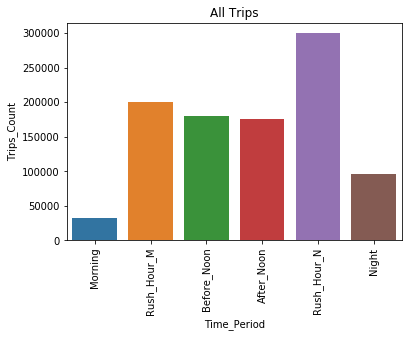

In [38]:
d = {'Time_Period': ['Morning', 'Rush_Hour_M','Before_Noon','After_Noon','Rush_Hour_N','Night'], 'Trips_Count': [33037, 199995,179307,176142,299626,95541]}
df = pd.DataFrame(data=d)
plt = sns.barplot(x="Time_Period", y="Trips_Count", data=df)
plt.set_title('All Trips')
plt.set_xticklabels(plt.get_xticklabels(), rotation=90)

The customer pattern is quite different from the subscriber one. While the subscribers have higher ridership during the rush hours, customers have the highest usage in the afternoon. This indicates that most subscribers might be locals working in the Bay areas, while customers might be more travellers visiting the city.

[Text(0,0,'Morning'),
 Text(0,0,'Rush_Hour_M'),
 Text(0,0,'Before_Noon'),
 Text(0,0,'After_Noon'),
 Text(0,0,'Rush_Hour_N'),
 Text(0,0,'Night')]

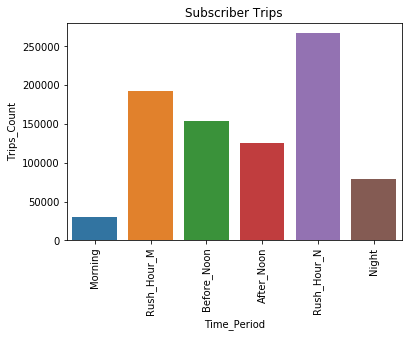

In [37]:
d_subscriber = {'Time_Period': ['Morning', 'Rush_Hour_M','Before_Noon','After_Noon','Rush_Hour_N','Night'], 'Trips_Count': [29521,192117,153407,125372,266764,79658]}
df_subscriber = pd.DataFrame(data=d_subscriber)
plt_subscriber = sns.barplot(x="Time_Period", y="Trips_Count", data=df_subscriber)
plt_subscriber.set_title('Subscriber Trips')
plt_subscriber.set_xticklabels(plt_subscriber.get_xticklabels(), rotation=90)

[Text(0,0,'Morning'),
 Text(0,0,'Rush_Hour_M'),
 Text(0,0,'Before_Noon'),
 Text(0,0,'After_Noon'),
 Text(0,0,'Rush_Hour_N'),
 Text(0,0,'Night')]

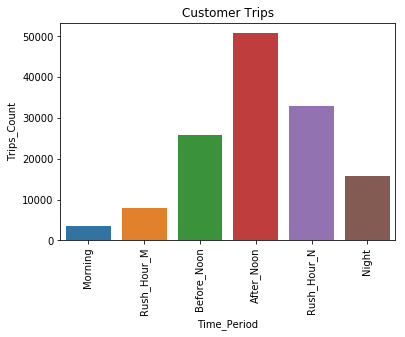

In [40]:
d_customer = {'Time_Period': ['Morning', 'Rush_Hour_M','Before_Noon','After_Noon','Rush_Hour_N','Night'], 'Trips_Count': [3516,7878,25900,50770,32862,15883]}
df_customer = pd.DataFrame(data=d_customer)
plt_customer = sns.barplot(x="Time_Period", y="Trips_Count", data=df_customer)
plt_customer.set_title('Customer Trips')
plt_customer.set_xticklabels(plt_customer.get_xticklabels(), rotation=90)

## III. Conclusion

* What are the 5 most popular trips as "commuter trips"?

    The most popular five trips are as below. However, subscribers and customers have quite distinctive usage patterns. Customers tend to be more near the tourism area and within only few stations.

In [1]:
! bq query --use_legacy_sql=false 'SELECT COUNT(*) AS count, start_station_name, end_station_name FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY start_station_name, end_station_name ORDER BY count DESC LIMIT 5'

Waiting on bqjob_r6f79f407d0d368c4_00000168cd8dff92_1 ... (0s) Current status: DONE   
+-------+-----------------------------------------+--------------------------------------+
| count |           start_station_name            |           end_station_name           |
+-------+-----------------------------------------+--------------------------------------+
|  9150 | Harry Bridges Plaza (Ferry Building)    | Embarcadero at Sansome               |
|  8508 | San Francisco Caltrain 2 (330 Townsend) | Townsend at 7th                      |
|  7620 | 2nd at Townsend                         | Harry Bridges Plaza (Ferry Building) |
|  6888 | Harry Bridges Plaza (Ferry Building)    | 2nd at Townsend                      |
|  6874 | Embarcadero at Sansome                  | Steuart at Market                    |
+-------+-----------------------------------------+--------------------------------------+


* What are the recommendations for offers?

    In order to increase ridership, I will recomment **an annual membership** with three major reasons:
    
    * **Subscirbers take much more rides than customers**
    
    Subscibers are annual or 30-day members, and 86.09% of all trips are made by subscribers. To increase the ridership, a membership pricing system might attract them better. However, further analysis is needed to determine whether an annual member or a 30-day membership is more suitable. 
    
    * **Higher ridership during rush hours**
    
    Both overall and subscriber-only time period graphs show that rush hours tend to have higher usage. It indicates that maybe the mojority of the users are locals who use bikes to avoid rush hour car traffic. If so, there could be daily bike share for many other locals. To increase the ridership, an annual membership will fit the best as it will become a habit for many locals.
    * **The duration tends to be short for subsciribers**
    
    Among subscriber made trips, the average duration is 6.84 minutes. This can help higher bike turnover.
    
Though the annual membership will be attractive to the potential subscribers, Ford GoBike **should not** ignore the tourism market. The other two alternatives -  a flat price for a single one-way trip and a day pass that allows unlimited 30-minute rides for 24 hours, both do not fit the tourism need. A flat price for a single one-way trip might be less optimal for higher turnover while the 30-minute ride is much less than the average riding time for customer. Instead of offering single pricing plan, Ford GoBike should conduct further analysis to offer flexible options.



## Appendix

1.Data Structure Queries

In [8]:
! bq query --use_legacy_sql=false 'SELECT count(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips`'

Waiting on bqjob_r17ebcd550a5451b2_00000168ccabc600_1 ... (0s) Current status: DONE   
+--------+
|  f0_   |
+--------+
| 983648 |
+--------+


In [4]:
!bq query --use_legacy_sql=false 'SELECT min(start_date), max(start_date) FROM `bigquery-public-data.san_francisco.bikeshare_trips`'

Waiting on bqjob_r5d5fe80524c9f92c_00000168cca0990b_1 ... (0s) Current status: DONE   
+---------------------+---------------------+
|         f0_         |         f1_         |
+---------------------+---------------------+
| 2013-08-29 09:08:00 | 2016-08-31 23:32:00 |
+---------------------+---------------------+


In [6]:
!bq query --use_legacy_sql=false 'SELECT count(distinct bike_number) FROM `bigquery-public-data.san_francisco.bikeshare_trips`'

Waiting on bqjob_r1f93df7b4c0b9ce6_00000168cca0c1bd_1 ... (0s) Current status: DONE   
+-----+
| f0_ |
+-----+
| 700 |
+-----+


2.Customer trip less than 1 minute

There are 7 trips within 1 minute, which could be trips cancelled last minute.

In [31]:
! bq query --use_legacy_sql=false 'SELECT count(*) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Customer" AND duration_sec<=60'

Waiting on bqjob_r7e587079c8fc5855_00000168cd0a789b_1 ... (0s) Current status: DONE   
+-----+
| f0_ |
+-----+
|   7 |
+-----+


3.Time period 

In [2]:
!bq query --use_legacy_sql=false 'SELECT COUNT(*) AS Morning FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(HOUR FROM start_date) >=0 AND EXTRACT(HOUR FROM start_date) < 7'
!bq query --use_legacy_sql=false 'SELECT COUNT(*) AS Rush_Hour_M FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(HOUR FROM start_date) >= 7 AND EXTRACT(HOUR FROM start_date) < 9'
!bq query --use_legacy_sql=false 'SELECT COUNT(*) AS Before_Noon FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(HOUR FROM start_date) >= 9 AND EXTRACT(HOUR FROM start_date) < 12'
!bq query --use_legacy_sql=false 'SELECT COUNT(*) AS After_Noon FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(HOUR FROM start_date) >= 12 AND EXTRACT(HOUR FROM start_date) < 16'
!bq query --use_legacy_sql=false 'SELECT COUNT(*) AS Rush_Hour_N FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(HOUR FROM start_date) >= 16 AND EXTRACT(HOUR FROM start_date) < 19'
!bq query --use_legacy_sql=false 'SELECT COUNT(*) AS Night FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(HOUR FROM start_date) >= 19 AND EXTRACT(HOUR FROM start_date) <= 24'

Waiting on bqjob_r42d79917340af033_00000168cd5ac863_1 ... (1s) Current status: DONE   
+---------+
| Morning |
+---------+
|   33037 |
+---------+
Waiting on bqjob_r73350bebcfc1f2c8_00000168cd5ae1fc_1 ... (0s) Current status: DONE   
+-------------+
| Rush_Hour_M |
+-------------+
|      199995 |
+-------------+
Waiting on bqjob_r26debd9af431c4b6_00000168cd5af509_1 ... (1s) Current status: DONE   
+-------------+
| Before_Noon |
+-------------+
|      179307 |
+-------------+
Waiting on bqjob_r46818278de4f650a_00000168cd5b0c5a_1 ... (0s) Current status: DONE   
+------------+
| After_Noon |
+------------+
|     176142 |
+------------+
Waiting on bqjob_r4946de7632e37b5_00000168cd5b1f0f_1 ... (0s) Current status: DONE   
+-------------+
| Rush_Hour_N |
+-------------+
|      299626 |
+-------------+
Waiting on bqjob_r14924dca7e4dd10a_00000168cd5b3245_1 ... (0s) Current status: DONE   
+-------+
| Night |
+-------+
| 95541 |
+-------+


In [35]:
# Subscriber only 
!bq query --use_legacy_sql=false 'SELECT COUNT(*) AS Morning FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(HOUR FROM start_date) >=0 AND EXTRACT(HOUR FROM start_date) < 7 AND subscriber_type = "Subscriber"'
!bq query --use_legacy_sql=false 'SELECT COUNT(*) AS Rush_Hour_M FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(HOUR FROM start_date) >= 7 AND EXTRACT(HOUR FROM start_date) < 9 AND subscriber_type = "Subscriber"'
!bq query --use_legacy_sql=false 'SELECT COUNT(*) AS Before_Noon FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(HOUR FROM start_date) >= 9 AND EXTRACT(HOUR FROM start_date) < 12 AND subscriber_type = "Subscriber"'
!bq query --use_legacy_sql=false 'SELECT COUNT(*) AS After_Noon FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(HOUR FROM start_date) >= 12 AND EXTRACT(HOUR FROM start_date) < 16 AND subscriber_type = "Subscriber"'
!bq query --use_legacy_sql=false 'SELECT COUNT(*) AS Rush_Hour_N FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(HOUR FROM start_date) >= 16 AND EXTRACT(HOUR FROM start_date) < 19 AND subscriber_type = "Subscriber"'
!bq query --use_legacy_sql=false 'SELECT COUNT(*) AS Night FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(HOUR FROM start_date) >= 19 AND EXTRACT(HOUR FROM start_date) <= 24 AND subscriber_type = "Subscriber"'

Waiting on bqjob_rfbe6f2f7de529df_00000168cd7f5eea_1 ... (0s) Current status: DONE   
+---------+
| Morning |
+---------+
|   29521 |
+---------+
Waiting on bqjob_r134c21f39db96db1_00000168cd7f73d4_1 ... (0s) Current status: DONE   
+-------------+
| Rush_Hour_M |
+-------------+
|      192117 |
+-------------+
Waiting on bqjob_r711041ba85bf64d3_00000168cd7f866c_1 ... (0s) Current status: DONE   
+-------------+
| Before_Noon |
+-------------+
|      153407 |
+-------------+
Waiting on bqjob_r986db1d049494ca_00000168cd7f9905_1 ... (0s) Current status: DONE   
+------------+
| After_Noon |
+------------+
|     125372 |
+------------+
Waiting on bqjob_r62854f4f24d4b396_00000168cd7fab95_1 ... (0s) Current status: DONE   
+-------------+
| Rush_Hour_N |
+-------------+
|      266764 |
+-------------+
Waiting on bqjob_r1a73cfef5e9f4e43_00000168cd7fbdd5_1 ... (0s) Current status: DONE   
+-------+
| Night |
+-------+
| 79658 |
+-------+


In [39]:
# Customer only 
!bq query --use_legacy_sql=false 'SELECT COUNT(*) AS Morning FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(HOUR FROM start_date) >=0 AND EXTRACT(HOUR FROM start_date) < 7 AND subscriber_type = "Customer"'
!bq query --use_legacy_sql=false 'SELECT COUNT(*) AS Rush_Hour_M FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(HOUR FROM start_date) >= 7 AND EXTRACT(HOUR FROM start_date) < 9 AND subscriber_type = "Customer"'
!bq query --use_legacy_sql=false 'SELECT COUNT(*) AS Before_Noon FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(HOUR FROM start_date) >= 9 AND EXTRACT(HOUR FROM start_date) < 12 AND subscriber_type = "Customer"'
!bq query --use_legacy_sql=false 'SELECT COUNT(*) AS After_Noon FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(HOUR FROM start_date) >= 12 AND EXTRACT(HOUR FROM start_date) < 16 AND subscriber_type = "Customer"'
!bq query --use_legacy_sql=false 'SELECT COUNT(*) AS Rush_Hour_N FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(HOUR FROM start_date) >= 16 AND EXTRACT(HOUR FROM start_date) < 19 AND subscriber_type = "Customer"'
!bq query --use_legacy_sql=false 'SELECT COUNT(*) AS Night FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(HOUR FROM start_date) >= 19 AND EXTRACT(HOUR FROM start_date) <= 24 AND subscriber_type = "Customer"'

Waiting on bqjob_r5b9336e4cd100a2b_00000168cd83fc09_1 ... (0s) Current status: DONE   
+---------+
| Morning |
+---------+
|    3516 |
+---------+
Waiting on bqjob_r704e76293e9a4be8_00000168cd840f83_1 ... (0s) Current status: DONE   
+-------------+
| Rush_Hour_M |
+-------------+
|        7878 |
+-------------+
Waiting on bqjob_r3132995f105508e9_00000168cd8423eb_1 ... (0s) Current status: DONE   
+-------------+
| Before_Noon |
+-------------+
|       25900 |
+-------------+
Waiting on bqjob_r4ed11ce940a09749_00000168cd84382f_1 ... (0s) Current status: DONE   
+------------+
| After_Noon |
+------------+
|      50770 |
+------------+
Waiting on bqjob_r410febbb7d70d63_00000168cd844b52_1 ... (0s) Current status: DONE   
+-------------+
| Rush_Hour_N |
+-------------+
|       32862 |
+-------------+
Waiting on bqjob_r5d58e0197eceda48_00000168cd845e2e_1 ... (0s) Current status: DONE   
+-------+
| Night |
+-------+
| 15883 |
+-------+
